 # EE0005 Mini-Project: Fake Job Detection

Unemployment rate skyrocketed during May 2020 to 14.3% in the USA alone because of Covid19 and major lockdowns. Job security was a major issue as many workers lost their jobs and have been actively looking for one since then. With an increase of workers actively looking for new jobs, an increase of fake job posting follows as scammers actively look for opportunities to take advantage of the desperateness of these people. Although we can tell that some job listings can be fake, during these desperate times, retrenched workers may take the risk and risk themselves getting scammed just for the job security

We decided to use the dataset real or fake job posting prediction from kaggle and look at how we can imporve it by using machine learning. The purpose is to fliter out fradulent data so that we can prevent scammers from having the opportunity to scam more desperate people.

## Import Essential Python Modules 

In [1]:
#Basic libraries and modules
import numpy as np
import pandas as pd
import seaborn as sb
import random
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.corpus import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import pycountry
import plotly.graph_objects as go

from wordcloud import WordCloud

from collections import Counter
pd.options.mode.chained_assignment = None 

# Part 1: Data Visualization And Analysis

In [2]:
#Use read_csv to import the dataset fake_job_postings
FakeJobData = pd.read_csv("fake_job_postings.csv")

In [3]:
#Shows all rows in the dataset
FakeJobData.head()

job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

In [4]:
#Shows a summary for the dataframe.
FakeJobData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [5]:
print("\nThe dataset has a shape of " + str(FakeJobData.shape))


The dataset has a shape of (17880, 18)


#### Visualize The Completeness Of Data

<AxesSubplot:>

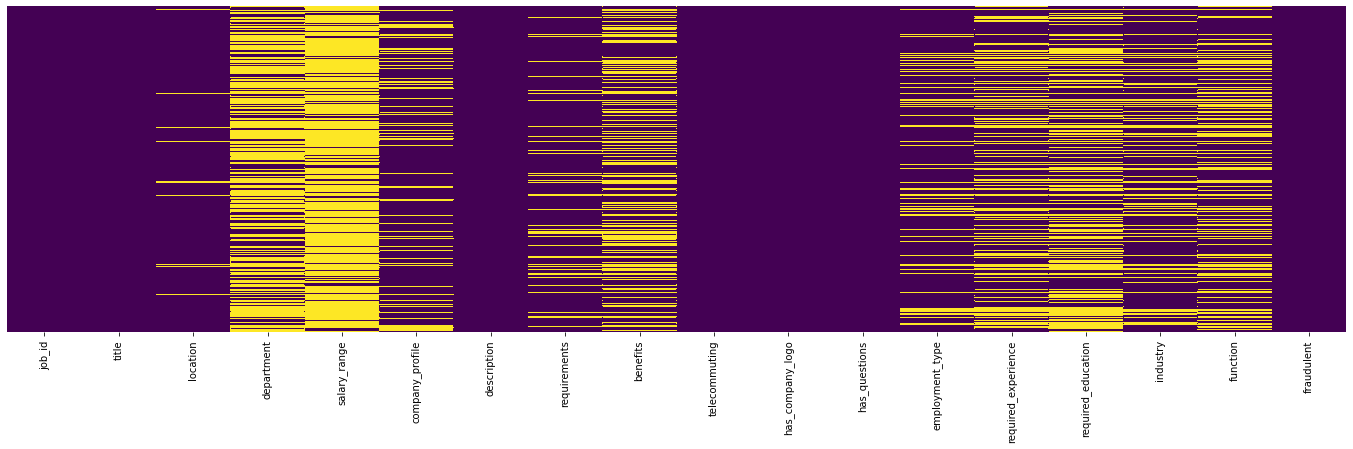

In [6]:
plt.figure(figsize=(24, 6))
sb.heatmap(FakeJobData.isnull(),yticklabels=False,cbar=False,cmap='viridis')

By visualing the completeness of the data, we can determine which data will not be very useful in determining fradulent data. We can fliter it out.

We can conclude that the data in the 'department' , 'salary_range' and 'required_education' column has a lot of null data which is not usefull in predicting fakejobs.

In [7]:
#Identify The Number Of Fraudulents In The Data
FakeJobData['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In the dataset, we have 866 fradulent data and 17014 non fradulent data. 

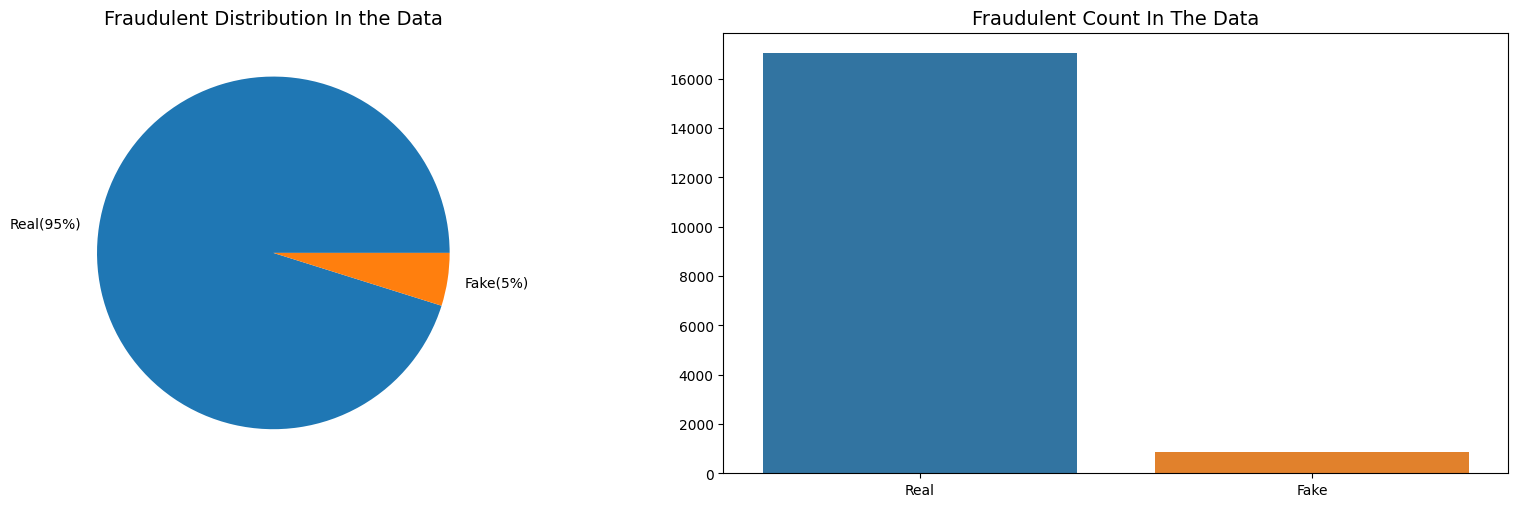

In [8]:
#Distribution of fradulent data and non-fradulent data in the dataset
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
plt.tight_layout()

FakeJobData["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real(95%)', 'Fake(5%)'])
temp = FakeJobData["fraudulent"].value_counts()
sb.barplot(x = temp.index, y = temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real", "Fake"])

axes[0].set_title('Fraudulent Distribution In the Data', fontsize=14)
axes[1].set_title('Fraudulent Count In The Data', fontsize=14)

plt.show()

We can visualise the amount of fake data compared to real data in the dataset.

#### Visualizing The Number Of Fraudulents In Each Column

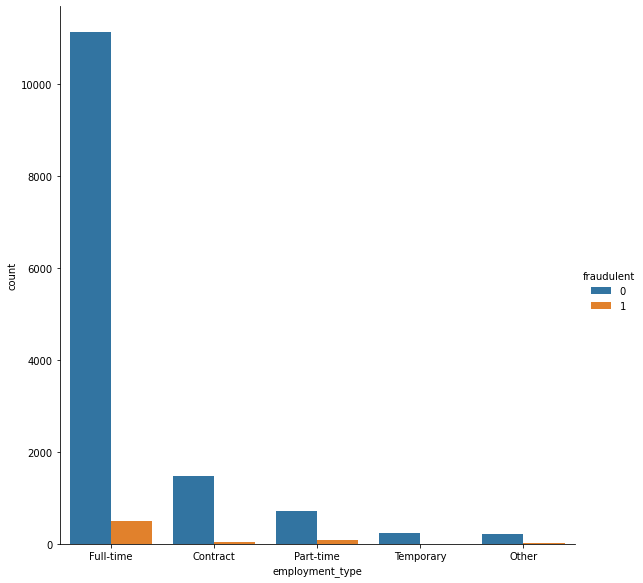

In [9]:
#shows the different frequencys of data.
sb.catplot(x = 'employment_type' , data = FakeJobData, kind = "count", height = 8,order=FakeJobData['employment_type'].value_counts().index, hue = 'fraudulent')

We observed that 'Full-time' has the highest count of non-fradulent data with respect to fradulent data.

We can assume that as many workers lost their job security, they are actively searching for new full time job. Therefore, scammers will target their fake listings on that category of people.

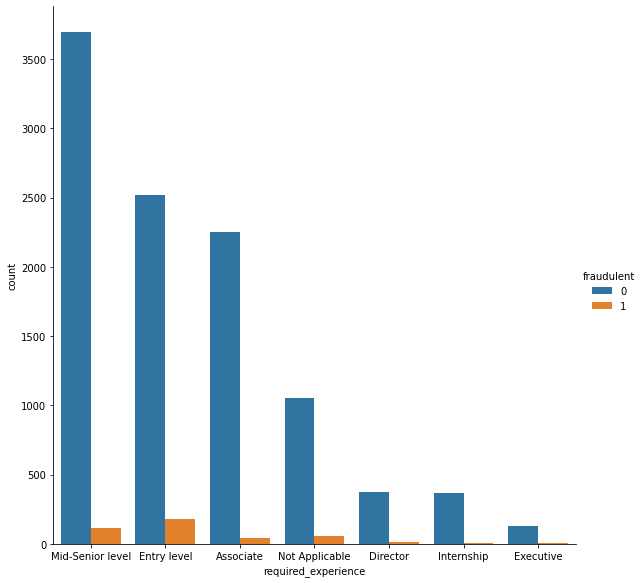

In [10]:
sb.catplot(x = 'required_experience' , data = FakeJobData, kind = "count", height = 8,order=FakeJobData['required_experience'].value_counts().index, hue = 'fraudulent')

Although we can observe that 'Mid-Senior level' position has the highest count of non-fradulent data where the highest count of fradulent data is in 'Entry level'.

We can assume that scammers target more on the entry level positions as those workers who are searching for a job may not have enough job experience to detect what is a fakejob making them the most gullible group.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, "Bachelor's Degree"),
  Text(1, 0, 'High School or equivalent'),
  Text(2, 0, 'Unspecified'),
  Text(3, 0, "Master's Degree"),
  Text(4, 0, 'Associate Degree'),
  Text(5, 0, 'Certification'),
  Text(6, 0, 'Some College Coursework Completed'),
  Text(7, 0, 'Professional'),
  Text(8, 0, 'Vocational'),
  Text(9, 0, 'Some High School Coursework'),
  Text(10, 0, 'Doctorate'),
  Text(11, 0, 'Vocational - HS Diploma'),
  Text(12, 0, 'Vocational - Degree')])

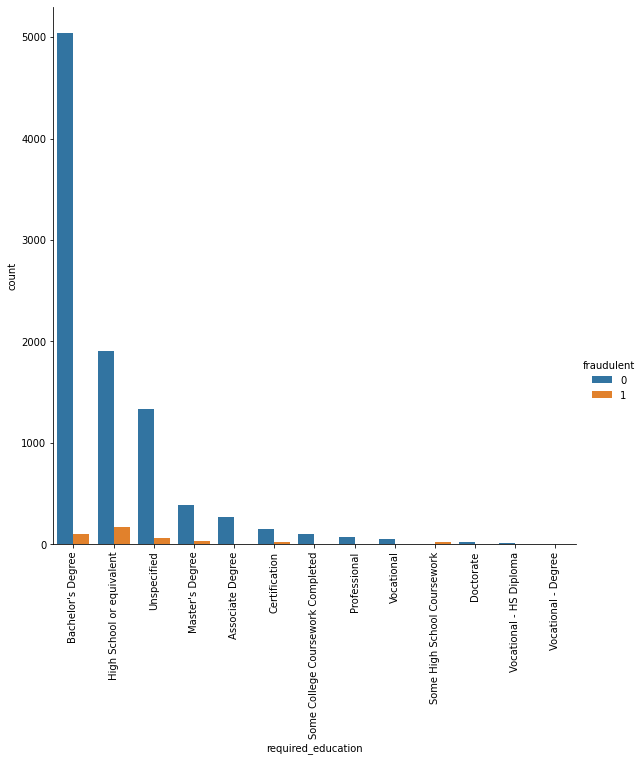

In [11]:
sb.catplot(x = 'required_education' , data = FakeJobData, kind = "count", height = 8,order=FakeJobData['required_education'].value_counts().index, hue = 'fraudulent')

plt.xticks(rotation=90)

We conclude that a huge amount of employers actively look for wokers with a 'Bachelor's Degree'. However we can see that there are more fradulent data in 'High School or equivanlent'

Same thing goes this set of data under column 'required_education'. Scammers actively target those with lower education so we can assume they are the most gullible ones.

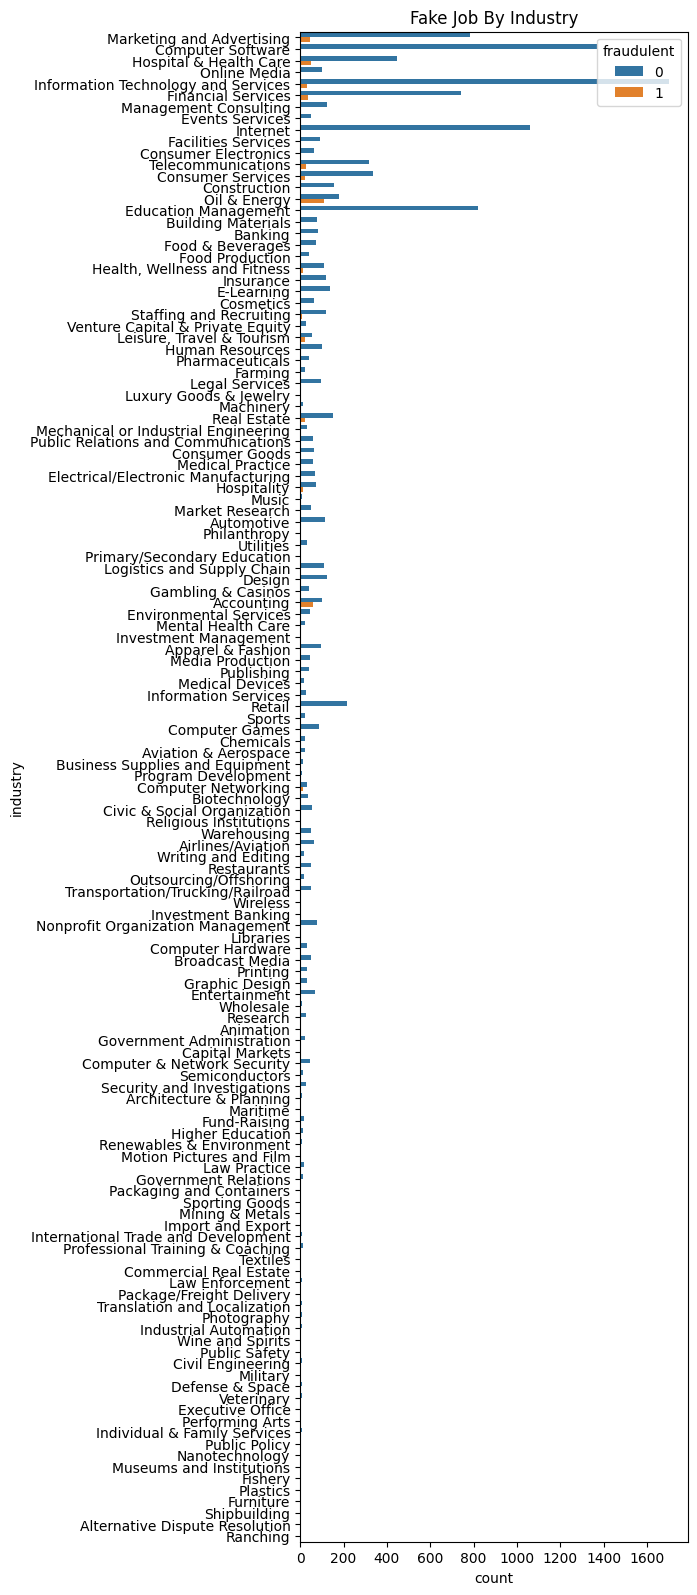

In [12]:
plt.figure(figsize=(5,20), dpi=100)
sb.countplot(y='industry', data=FakeJobData, hue='fraudulent')
plt.title('Fake Job By Industry')
plt.show()

Under the data column 'industry', we can see that there is no correlation of higher count of non-fradulent data will have an increase in fradulent data in one sector. Infact, we can assume that scammers are actively targeting those workers job security who are hit the most in their respective industry by Covid19

For example 'Oil & Energy'. We do know that the Oil and Energy sector was largely hit with the lockdowns. We can also see that not many employers are looking for new workers under the same industry.There we can assume that scammers will be looking for opportunities to find those desperate and gullible enough who are hardest hit by Covid19 in their respective industry.

####  Comparing the number of character in the fake post and real post 
Next we look at the patterns of word data in 'description', 'requirements' and 'benefits'.
This step helps to distinguish pattern in the fake and real post based on number of charater used in the post.

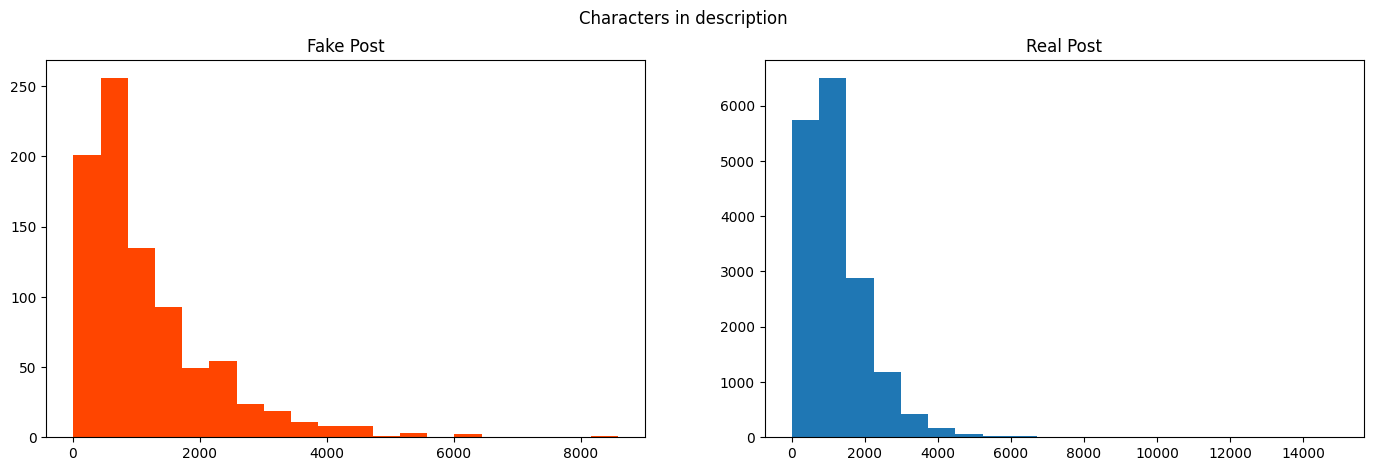

In [13]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=FakeJobData[FakeJobData["fraudulent"]==1]['description'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=FakeJobData[FakeJobData["fraudulent"]==0]['description'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in description')
plt.show()

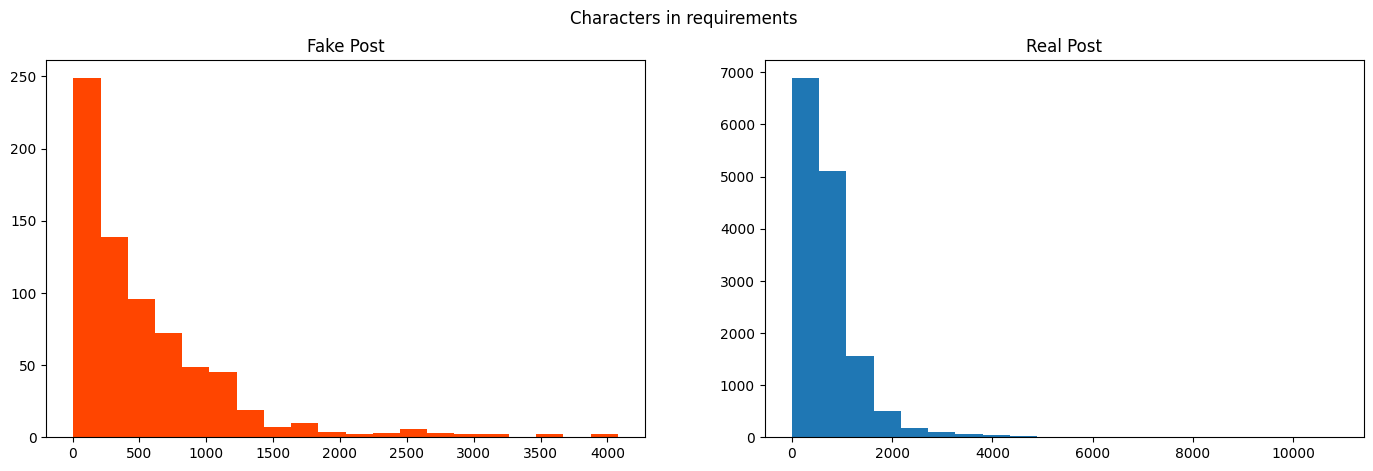

In [14]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=FakeJobData[FakeJobData["fraudulent"]==1]['requirements'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=FakeJobData[FakeJobData["fraudulent"]==0]['requirements'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in requirements')
plt.show()

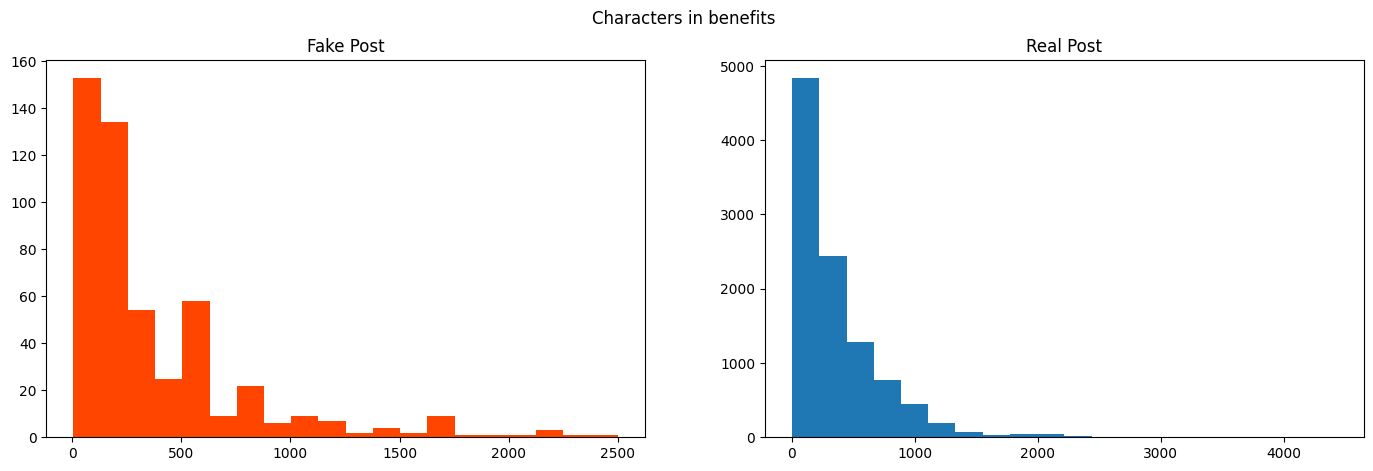

In [15]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=FakeJobData[FakeJobData["fraudulent"]==1]['benefits'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=FakeJobData[FakeJobData["fraudulent"]==0]['benefits'].str.len()
ax2.hist(length,bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in benefits')
plt.show()

Based on the 3 different datas being represented we can see that real job data also follow a certain pattern where they more than 250 chars per post in their respective category.

We can assume that most fradulent post usually have less than 250 characters per post but we cannot be certain.

In [16]:
#Assign 3 variables and remove e
FakeJobData['text'] = FakeJobData['description']+FakeJobData['requirements']+FakeJobData['benefits']
FakeJobData['text'] = FakeJobData['text'].str.replace(r'[^\w\s]+', '')
FakeJobData['text'] = FakeJobData['text'].astype('str')

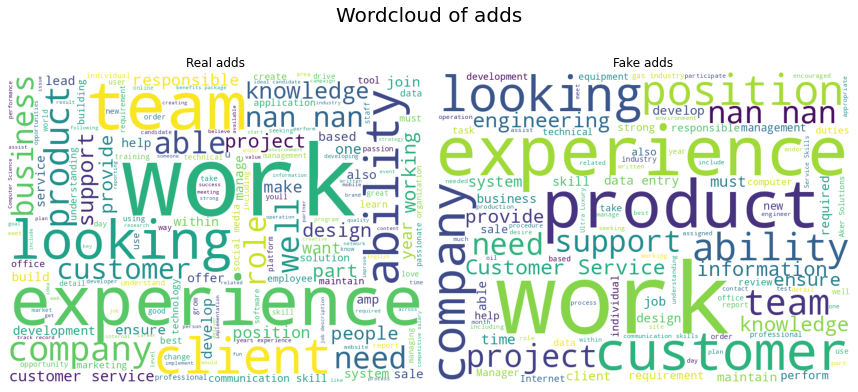

In [17]:
#Determine the frequency of words used in Read and Fake ads
wordcloud_real = WordCloud(
                width = 800, height = 600, 
                background_color ='white', 
                stopwords = stopwords.words('english'), 
                min_font_size = 10).generate(" ".join(FakeJobData[FakeJobData['fraudulent'] == 0].text))

wordcloud_fake =WordCloud(
                width = 800, height = 600, 
                background_color ='white', 
                stopwords = stopwords.words('english'), 
                min_font_size = 10).generate(" ".join(FakeJobData[FakeJobData['fraudulent'] == 1].text))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Wordcloud of adds', fontsize=20)
ax1.imshow(wordcloud_real)
ax1.set_title('Real adds')
ax1.axis('off')
ax2.imshow(wordcloud_fake)
ax2.set_title('Fake adds')
ax2.axis('off')
plt.tight_layout(pad = 1)
plt.show()

We also see that despite there are similar terms of words used in both Real and Fake adds, we can use the weightage of the frequency of words used for our machine learning to determine fradulent or non-fradulent data.

## Country Heat Map

In this step, we will visualize the number of fake jobs by countries using ploty heat map.

#### First Step: Identify fake jobs by location

In [18]:
totalcountry = []

for x in range(len(FakeJobData['fraudulent'])):
    if(FakeJobData['fraudulent'][x] == 1):
        totalcountry.append(FakeJobData['location'][x])

In [19]:
ptotalcountry = pd.DataFrame(totalcountry)

In [20]:
ptotalcountry

0
0                     US, , Stocton, CA
1                                   NaN
2                                    US
3                       PK, SD, Karachi
4    US, CA, Bakersfield, CA / Mt. Poso
..                                  ...
861                 US, CA, Los Angeles
862                     AU, NSW, Sydney
863                      PL, MZ, Warsaw
864                    US, NY, New York
865                     US, IL, Chicago

[866 rows x 1 columns]

#### Step 2: Remove irrelevant location data and count  number of occurrence of each country

In [21]:
# Convert data to string in order to apply split function
FakeJobData['location'] = FakeJobData['location'].astype(str)
ptotalcountry = ptotalcountry.astype(str)

In [22]:
def split(location):
    l = location.split(',')
    return l[0]

FakeJobData['country'] = FakeJobData.location.apply(split)
ptotalcountry[0] = ptotalcountry[0].apply(split)

In [23]:
countrycount = dict(FakeJobData.country.value_counts()[:14])
fakecountrycount = dict(ptotalcountry[0].value_counts()[:14])

In [24]:
countrycount

{'US': 10656,
 'GB': 2384,
 'GR': 940,
 'CA': 457,
 'DE': 383,
 'nan': 346,
 'NZ': 333,
 'IN': 276,
 'AU': 214,
 'PH': 132,
 'NL': 127,
 'BE': 117,
 'IE': 114,
 'SG': 80}

In [25]:
fakecountrycount

{'US': 730,
 'AU': 40,
 'GB': 23,
 'nan': 19,
 'MY': 12,
 'CA': 12,
 'QA': 6,
 'BH': 5,
 'IN': 4,
 'PL': 3,
 'TW': 2,
 'ES': 1,
 'ZA': 1,
 'PH': 1}

In [26]:
#Remove unknown country
countrycount.pop('nan')
fakecountrycount.pop('nan')

19

In [27]:
#Show Current Countries and counts 
print('Total Jobs Per Country:', countrycount,"\n")

print('Total Fake Jobs Per Country',fakecountrycount)

Total Jobs Per Country: {'US': 10656, 'GB': 2384, 'GR': 940, 'CA': 457, 'DE': 383, 'NZ': 333, 'IN': 276, 'AU': 214, 'PH': 132, 'NL': 127, 'BE': 117, 'IE': 114, 'SG': 80} 

Total Fake Jobs Per Country {'US': 730, 'AU': 40, 'GB': 23, 'MY': 12, 'CA': 12, 'QA': 6, 'BH': 5, 'IN': 4, 'PL': 3, 'TW': 2, 'ES': 1, 'ZA': 1, 'PH': 1}


#### Step 3: Convert data to pandas dataframe

In [28]:
#Convert dictionary to pandas dataframe 
mappd = pd.DataFrame.from_dict(countrycount, orient="index").reset_index()
Fakemappd = pd.DataFrame.from_dict(fakecountrycount, orient="index").reset_index()

In [29]:
#Rename columns to country and counts
mappd.columns = ['Country Code', 'counts']
Fakemappd.columns = ['Country Code', 'counts']

In [30]:
mappd['Country Name'] = [0,0,0,0,0,0,0,0,0,0,0,0,0]
Fakemappd['Country Name'] = [0,0,0,0,0,0,0,0,0,0,0,0,0]

new_df = mappd['Country Code'].apply(lambda x: pycountry.countries.get(alpha_3=x).name if len(x) == 3 else pycountry.countries.get(alpha_2=x).name)
Fakenew_df = Fakemappd['Country Code'].apply(lambda x: pycountry.countries.get(alpha_3=x).name if len(x) == 3 else pycountry.countries.get(alpha_2=x).name)

for x in range(len(mappd)):
    mappd.loc[:,('Country Name')][x] = new_df[x]
for x in range(len(Fakemappd)):
    Fakemappd.loc[:,('Country Name')][x] = new_df[x]

In [31]:
Fakemappd

Country Code  counts    Country Name
0            US     730   United States
1            AU      40  United Kingdom
2            GB      23          Greece
3            MY      12          Canada
4            CA      12         Germany
5            QA       6     New Zealand
6            BH       5           India
7            IN       4       Australia
8            PL       3     Philippines
9            TW       2     Netherlands
10           ES       1         Belgium
11           ZA       1         Ireland
12           PH       1       Singapore

#### Step 4: Convert country code from alpha2 to alpha3

In [32]:
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

codes = [countries.get(country, 'Unknown code') for country in mappd['Country Name']]
Fakecodes = [countries.get(country, 'Unknown code') for country in Fakemappd['Country Name']]

In [33]:
#Convert Country code from alpha2 to alpha3
for x in range(len(mappd)):
    mappd['Country Code'][x] = codes[x]
    
for x in range(len(Fakemappd)):
    Fakemappd['Country Code'][x] = Fakecodes[x]

In [34]:
#Display Current Data
Fakemappd

Country Code  counts    Country Name
0           USA     730   United States
1           GBR      40  United Kingdom
2           GRC      23          Greece
3           CAN      12          Canada
4           DEU      12         Germany
5           NZL       6     New Zealand
6           IND       5           India
7           AUS       4       Australia
8           PHL       3     Philippines
9           NLD       2     Netherlands
10          BEL       1         Belgium
11          IRL       1         Ireland
12          SGP       1       Singapore

#### Step 5: Plot Heat Map

In [35]:
#Plot Country Number based on Total Job Postings 
fig = go.Figure(data=go.Choropleth(
    locations = mappd['Country Code'],
    z = mappd['counts'],
    text = mappd['Country Name'],
    colorscale = 'agsunset',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=1,
    colorbar_tickprefix = '',
    colorbar_title = 'Counts',
))

fig.update_layout(
    title_text='Job Number By Countries',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

In [36]:
#Plot Country Number based on Total Fake Job Postings 
fig = go.Figure(data=go.Choropleth(
    locations = Fakemappd['Country Code'],
    z = Fakemappd['counts'],
    text = Fakemappd['Country Name'],
    colorscale = 'gray',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=1,
    colorbar_tickprefix = '',
    colorbar_title = 'Counts',
))

fig.update_layout(
    title_text='Fake Job Number By Countries',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

# Part 2: Data Preparation And Cleaning (NLP)
Data Preparation and cleaning is a mandatory step when we are working with text in Natural Language Processing. It helps to get rid of unhelpful parts of the data, or noise, by converting all characters to lowercase, removing punctuations marks, and removing stop words and typos.

#### Identify Null Data
The first step of data cleaning is to identify the number of null datas in the dataset. 

In [37]:
#List Down All Null Datas
FakeJobData.isnull().sum()

job_id                     0
title                      0
location                   0
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
text                       0
country                    0
dtype: int64

As shown above, datas such as salary_range and department have significant amount of null datas. Categorical Data which contains large amount of null datas will no longer be used for analysis. 

#### Identify Categorical data for NLP

In [38]:
FakeJobData.head()

job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent                                               text country  
0           0                                                nan      US  
1           0  Organised  Focused  Vibrant  AwesomeDo you hav...      NZ  
2           0                                                nan      US  
3           0  THE COMPANY ESRI  Environmental Systems Resear...      US  
4           0  JOB TITLE Itemization Review ManagerLOCATION F...      US

#### Removing Punctuation Marks
Punctuation Marks carry no meaning and should be removed

In [39]:
print("Before removing punctuation marks")
print(FakeJobData['description'])

Before removing punctuation marks
0        Food52, a fast-growing, James Beard Award-winn...
1        Organised - Focused - Vibrant - Awesome!Do you...
2        Our client, located in Houston, is actively se...
3        THE COMPANY: ESRI – Environmental Systems Rese...
4        JOB TITLE: Itemization Review ManagerLOCATION:...
                               ...                        
17875    Just in case this is the first time you’ve vis...
17876    The Payroll Accountant will focus primarily on...
17877    Experienced Project Cost Control Staff Enginee...
17878    Nemsia Studios is looking for an experienced v...
17879    Who are we?Vend is an award winning web based ...
Name: description, Length: 17880, dtype: object


In [40]:
columns = ['description', 'requirements', 'benefits']

for colu in columns:
    FakeJobData[colu] = FakeJobData[colu].str.replace(r'[^\w\s]+', '')

In [41]:
print("After removing punctuation marks")
print(FakeJobData['description'])

After removing punctuation marks
0        Food52 a fastgrowing James Beard Awardwinning ...
1        Organised  Focused  Vibrant  AwesomeDo you hav...
2        Our client located in Houston is actively seek...
3        THE COMPANY ESRI  Environmental Systems Resear...
4        JOB TITLE Itemization Review ManagerLOCATION F...
                               ...                        
17875    Just in case this is the first time youve visi...
17876    The Payroll Accountant will focus primarily on...
17877    Experienced Project Cost Control Staff Enginee...
17878    Nemsia Studios is looking for an experienced v...
17879    Who are weVend is an award winning web based p...
Name: description, Length: 17880, dtype: object


#### Convert To Lower Case
It is necessary to convert the text to lower case as it is case sensitive. It also helps to maintain the consistency flow during the NLP tasks. 

In [42]:
columns = ['description', 'requirements', 'benefits']

In [43]:
for colu in columns:
    FakeJobData[colu] = FakeJobData[colu].str.lower()

#### Tokenize
Before processing a natural language, we need to identify the words that constitute a string of characters. That’s why tokenization is the most basic step to proceed with NLP (text data). This is important because the meaning of the text could easily be interpreted by analyzing the words present in the text. Furthermore it gets the text into a format that’s easier to convert to raw numbers, which can actually be used for processing. 

In [44]:
tokenizer = RegexpTokenizer("[\w']+")

In [45]:
columns = ['title','company_profile', 'description', 'requirements', 'benefits']

for colu in columns:
    FakeJobData[colu] = FakeJobData[colu].apply(str)
    FakeJobData[colu] = FakeJobData[colu].map(tokenizer.tokenize)

In [46]:
print(FakeJobData['description'])

0        [food52, a, fastgrowing, james, beard, awardwi...
1        [organised, focused, vibrant, awesomedo, you, ...
2        [our, client, located, in, houston, is, active...
3        [the, company, esri, environmental, systems, r...
4        [job, title, itemization, review, managerlocat...
                               ...                        
17875    [just, in, case, this, is, the, first, time, y...
17876    [the, payroll, accountant, will, focus, primar...
17877    [experienced, project, cost, control, staff, e...
17878    [nemsia, studios, is, looking, for, an, experi...
17879    [who, are, wevend, is, an, award, winning, web...
Name: description, Length: 17880, dtype: object


#### Removing Stop words

Removing stop words helps the model to consider only key features as these words also don't carry much information

In [47]:
from collections import Counter

In [48]:
#Identify common stop words using nltk module
filtered_words = stopwords.words('english')

#print the result
print(filtered_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#### To improve the processing time, we used counter to create a dictionary of stopwords.

#### The main reason of using dictionar is that dictionary provides faster search (time = O(1)) rather than doing it on list (time = O(stopwords)).

#### By doing so, speed is increased by at least 5 times.

In [49]:
stopwords_dict = Counter(filtered_words)

In [50]:
print('Before Removing Stop Words')

print(FakeJobData['description'][0:25])

Before Removing Stop Words
0     [food52, a, fastgrowing, james, beard, awardwi...
1     [organised, focused, vibrant, awesomedo, you, ...
2     [our, client, located, in, houston, is, active...
3     [the, company, esri, environmental, systems, r...
4     [job, title, itemization, review, managerlocat...
5     [job, overviewapex, is, an, environmental, con...
6     [your, responsibilities, manage, the, englishs...
7     [who, is, airenvyhey, there, we, are, seasoned...
8     [implementationconfigurationtestingtraining, o...
9     [the, customer, service, associate, will, be, ...
10    [position, url_86fd830a95a64e2b30ceed829e63fd3...
11    [transferwise, is, the, clever, new, way, to, ...
12    [the, applications, developer, digital, will, ...
13    [event, industry, installers, needed, orlando,...
14    [are, you, interested, in, a, satisfying, and,...
15    [about, vault, dragon, vault, dragon, is, drop...
16    [we, are, looking, for, a, handson, qa, leader...
17    [government, fu

In [51]:
columns = ['description', 'requirements', 'benefits']
for colu in columns:
    for x in range(len(FakeJobData[colu])):
         FakeJobData.loc[:, (colu)][x] = [word for word in FakeJobData.loc[:, (colu)][x] if word not in stopwords_dict]

In [52]:
print('After Removing Stop Words')

print(FakeJobData['description'][0:25])

After Removing Stop Words
0     [food52, fastgrowing, james, beard, awardwinni...
1     [organised, focused, vibrant, awesomedo, passi...
2     [client, located, houston, actively, seeking, ...
3     [company, esri, environmental, systems, resear...
4     [job, title, itemization, review, managerlocat...
5     [job, overviewapex, environmental, consulting,...
6     [responsibilities, manage, englishspeaking, ed...
7     [airenvyhey, seasoned, entrepreneurs, heart, s...
8     [implementationconfigurationtestingtraining, o...
9     [customer, service, associate, based, phoenix,...
10    [position, url_86fd830a95a64e2b30ceed829e63fd3...
11    [transferwise, clever, new, way, move, money, ...
12    [applications, developer, digital, develop, pa...
13    [event, industry, installers, needed, orlando,...
14    [interested, satisfying, financially, rewardin...
15    [vault, dragon, vault, dragon, dropbox, physic...
16    [looking, handson, qa, leader, talented, rampd...
17    [government, fun

#### Data Stemming 
Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language

In [53]:
from functools import lru_cache

In [54]:
columns = ['description', 'requirements', 'benefits']

ps = PorterStemmer()

wordstem = lru_cache(maxsize=50000)(ps.stem)

#### Similar to the removing stop words optimization, lru_cache is added to improve the processing speed of the stemming algorithm.

In [55]:
print('Before Stemming')

print(FakeJobData['description'][-10:])

Before Stemming
17870    [activity, searching, senior, financial, analy...
17871    [requires, skilled, work, operating, commercia...
17872    [flites, saas, display, ad, platform, fuels, w...
17873    [responsibilitieswill, facilitate, recruiting,...
17874    [sr, javascript, developer, experience, 410, y...
17875    [case, first, time, youve, visited, website, v...
17876    [payroll, accountant, focus, primarily, payrol...
17877    [experienced, project, cost, control, staff, e...
17878    [nemsia, studios, looking, experienced, visual...
17879    [wevend, award, winning, web, based, point, sa...
Name: description, dtype: object


In [56]:
for colu in columns:
    for x in range(len(FakeJobData[colu])):
        for y in range(len(FakeJobData[colu][x])):
            FakeJobData[colu][x][y] = wordstem(FakeJobData[colu][x][y])

In [57]:
print('After Stemming')

print(FakeJobData['description'][-10:])

After Stemming
17870    [activ, search, senior, financi, analyst, supp...
17871    [requir, skill, work, oper, commerci, truck, l...
17872    [flite, saa, display, ad, platform, fuel, worl...
17873    [responsibilitieswil, facilit, recruit, hire, ...
17874    [sr, javascript, develop, experi, 410, year, l...
17875    [case, first, time, youv, visit, websit, vend,...
17876    [payrol, account, focu, primarili, payrol, fun...
17877    [experienc, project, cost, control, staff, eng...
17878    [nemsia, studio, look, experienc, visualgraph,...
17879    [wevend, award, win, web, base, point, sale, s...
Name: description, dtype: object


# Part 3: Training and Predicting

For this part of the project, the processed datas will be converted to matrixs of token counts. 

The data will then be trained using machine learning model to predict the fake jobs

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000, min_df=10, max_df=0.7, stop_words=stopwords.words('english'))
#print(len(vectorizer.get_feature_names())
#print(pd.DataFrame(x.A, columns=vectorizer.get_feature_names()).to_string())
      
text_1=pd.array(FakeJobData['description'].astype(str))
x = vectorizer.fit_transform(text_1)
X = x.toarray()

text_2 = pd.array(FakeJobData['requirements'].astype(str))
x_2 = vectorizer.fit_transform(text_2)
X_2 = x_2.toarray()

text_3 = pd.array(FakeJobData['benefits'])
x_3 = vectorizer.fit_transform(text_2)
X_3 = x_2.toarray()

X_ALL = np.hstack((X, X_2, X_3))

from sklearn.model_selection import train_test_split
lable= FakeJobData['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X_ALL, lable, test_size=0.2, stratify = lable)

We used CountVectorizer to list out the top 1000 words that apear the most. Then we compare every single word in our data with the list, if the word in the data is also in the top 1000 word list, we put a 1, otherwise we put a 0. By doing so, we convert the text data into numerical array.
We then use hstack to combine the array from three kinds of data.

In [59]:
print(X)

[[0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [60]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=5, random_state=0)
classifier.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=5, random_state=0)

We apply the data into randomforest. Here, we use the existence of the 1000 words as features.
The only parameter we can adjust is n_estimators, which is set to 5 in this instance.

In [61]:
y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.93      0.51      0.66       173

    accuracy                           0.97      3576
   macro avg       0.95      0.76      0.82      3576
weighted avg       0.97      0.97      0.97      3576

Test fit accuracy: 0.9745525727069351


<AxesSubplot:>

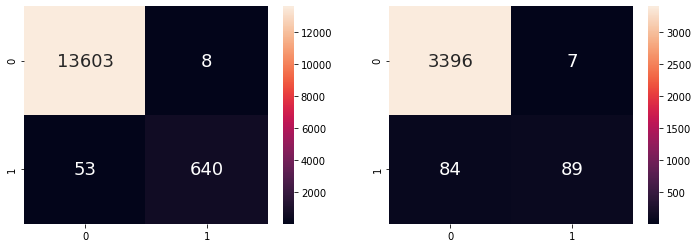

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(y_test,y_pred))
print("Test fit accuracy:", accuracy_score(y_test, y_pred))

#print heat map
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])

sb.heatmap(confusion_matrix(y_test, y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

The prediction result is shown. 
Since in our data set, there are way more true adds than fake adds, the precision score isn't the part we should focus the most on. Instead, we should focus on the recall score.
From recall score, we can see that almost all the data we said real are actually real. However some of the fake datas are mispredicted to be real.
This result doesn't really meets our expetation.

In [63]:
feature_imp = pd.Series(classifier.feature_importances_)
len(feature_imp.index) #Dimension 3000, first 1000 for "description", second 1000 for "requirements", last 1000 for "benefit"

3000

In [64]:
imp_description= 0
for i in range(1000):
    imp_description += feature_imp[i]
    
imp_requirements=0
for i in range(1000):
    imp_requirements += feature_imp[i+1000]
    
imp_benefit = 0
for i in range(1000):
    imp_benefit += feature_imp[i+2000]
    
print("improtance of description: ", imp_description)
print("improtance of requirements: ", imp_requirements)
print("improtance of benefit: ", imp_benefit)

improtance of description:  0.6122144579512009
improtance of requirements:  0.1940109844931996
improtance of benefit:  0.1937745575555992


From the reuslt, we can see that description plays the most inportant in our algorithm. The reason might be that description has the most words.

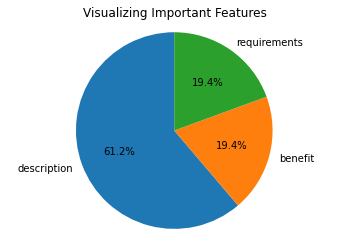

In [65]:
"""
%matplotlib inline
# Creating a bar plot
sb.barplot(x=[imp_description, imp_requirements, imp_benefit], y=["description", "requirements" ,"benefit"])

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
"""

labels = 'description', 'benefit', 'requirements'
sizes = [imp_description, imp_benefit, imp_requirements]

fig1, ax1 = plt.subplots()
plt.title("Visualizing Important Features")
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Add Non NLP Feature

In [66]:
#load origin data again
FakeJobData_org = pd.read_csv("fake_job_postings.csv")

In [67]:
#company_logo
#convert shape to (17880,1) (set np as 2d array and using transpose T)
feature_logo = np.array([FakeJobData_org['has_company_logo']]).T

#question
feature_question = np.array([FakeJobData_org['has_questions']]).T

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.92      0.50      0.65       173

    accuracy                           0.97      3576
   macro avg       0.95      0.75      0.82      3576
weighted avg       0.97      0.97      0.97      3576

Test fit accuracy: 0.9737136465324385


<AxesSubplot:>

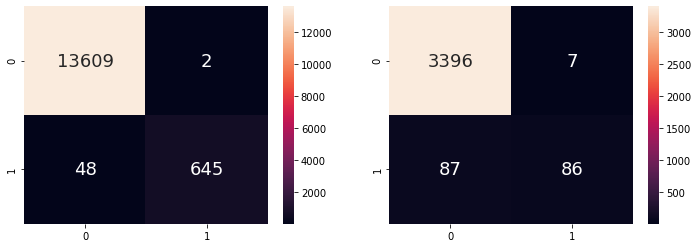

In [68]:
#hstack all feature
X_ALL = np.hstack((X_ALL, feature_logo, feature_question))

#split data and training
lable= FakeJobData['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X_ALL, lable, test_size=0.2, stratify = lable)
classifier = RandomForestClassifier(n_estimators=5, random_state=0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)

print(classification_report(y_test,y_pred))
print("Test fit accuracy:", accuracy_score(y_test, y_pred))

#print heat map
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])

sb.heatmap(confusion_matrix(y_test, y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

After adding non text information, we can see that the result doesn't change much. Thus, we can suggess that non text information isn't as important in our algorithm.

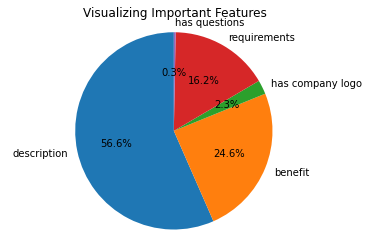

In [69]:
#show features importances
feature_imp = pd.Series(classifier.feature_importances_)

#3002 features, 2nd last for 'has_company_logo', last for has_questions
imp_description= 0
for i in range(1500):
    imp_description += feature_imp[i]
    
imp_benefit = 0
for i in range(1500):
    imp_benefit += feature_imp[i+1500]
    
imp_company_logo = feature_imp[3000]

imp_question = feature_imp[3001]


"""%matplotlib inline
# Creating a bar plot
sb.barplot(x=[imp_description, imp_requirements, imp_benefit,imp_company_logo, imp_question], 
            y=["description", "requirements" ,"benefit","has company logo","has questions"])

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
"""

labels = 'description', 'benefit', 'has company logo', 'requirements' ,'has questions'
sizes = [imp_description, imp_benefit, imp_company_logo, imp_requirements,  imp_question]

fig1, ax1 = plt.subplots()
plt.title("Visualizing Important Features")
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

It can be seen that non text information plays a really small role in our algorithm. The reason is because we treat the non text information as one single feature, which weights as much as every single word in other section.

## K-Fold -- Check for overfitting

In [70]:
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Parameter
forest_n = (2,3,4,5,6,7,8,9,10,11,12)
kfold_n = 5
score_label = 'f1_score' # f1_score, recall_score, accuracy_score

ave_score = []

kf = KFold(n_splits= kfold_n, random_state=None, shuffle=False)
for n in forest_n:
    score_record = []
    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X_ALL[train_index], X_ALL[test_index], lable[train_index], lable[test_index]
        classifier = RandomForestClassifier(n_estimators=n, random_state=0)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        if score_label == 'f1_score' :
            score = f1_score(y_test, y_pred, average='weighted')
        elif score_label == 'recall_score' : 
            score = recall_score(y_test, y_pred, average='weighted')
        elif score_label == 'accuracy_score' :     
            score = accuracy_score(y_test, y_pred)
        score_record.append(score)
    
    ave_score.append(sum(score_record) / len(score_record))
                     
    print("n_estimators = ", n ,",", score_label," mean =",(sum(score_record) / len(score_record)))

n_estimators =  2 , f1_score  mean = 0.9607578982812033
n_estimators =  3 , f1_score  mean = 0.9642067281993496
n_estimators =  4 , f1_score  mean = 0.9644451677965991
n_estimators =  5 , f1_score  mean = 0.9678506351189071
n_estimators =  6 , f1_score  mean = 0.9666677594135171
n_estimators =  7 , f1_score  mean = 0.9678842795408897
n_estimators =  8 , f1_score  mean = 0.9673646080599875
n_estimators =  9 , f1_score  mean = 0.9681249521409718
n_estimators =  10 , f1_score  mean = 0.9671158039584101
n_estimators =  11 , f1_score  mean = 0.9683071820085267
n_estimators =  12 , f1_score  mean = 0.9675809598865616


To justify that we choose a proper n_estimater parameter in our algorithm, we ran the K-fold algorithm with various n values.
Since we only did train-test split once in our random forest, K-fold is used to prevent the situation that too many outliers was distributed to test data causing our algorithm to be not accurate.

Text(0.5, 1.0, 'Visualizing n-estimators used to accuricy')

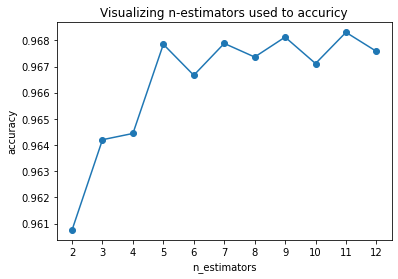

In [71]:
import matplotlib.ticker as ticker
tick_spacing = 1
fig, ax = plt.subplots(1,1)
plt.plot(forest_n,ave_score,"o-")
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.title("Visualizing n-estimators used to accuricy")

From the graph, we can see that when n is less than 5, the larger n is used, the more accurate our model is. Thus in this range of n, our model is underfitting. We can increase the feature used.
When n is larger than five, eventhough larger n still result in more accurate result, the improvement is really small. Furthermore, the accuracy starts to oscillate. This means that our model is overfitting for such large n.
Therefore, we believe n=5 is the best value for analysis.

# Conclusion

In conclusion, we used the api of countvector as we deemed the by predicting fradulent data based on the frequency of words will give the most accurate results through using randomforest. We also added two non nlp features so that we can further improve on our training dataset to enable a higher accuracy in predicitng fradulent data. In the end, we used K-fold and various n_estimators to justify that our algorithm isn't underfitting or overfitting.